# Library

In [1]:
# import torchvision
# torchvision.models.vgg16(pretrained=True).features[:4].eval(),      # 64,H,W 


In [2]:
import os
import torch
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
from torchvision.utils import make_grid
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

from model.pgflow import PGFlowV3
from model.landmark_detector.landmark_detector import FacialLandmarkDetector
from model.pgflow.module import InsightFaceModule #get_header
from util import computeGaussian, draw_edge

print(torch.cuda.is_available())


True


In [3]:
tt = T.ToTensor()
ptt = T.PILToTensor()
ttp = T.ToPILImage()

# Model

In [4]:
def load_landmark_detector():
    ckpt_path = '/home/dajinhan/nas_dajinhan/models/landmark_detector/checkpoint/mobilefacenet_model_best.pth.tar'
    pretrained = {'ckpt_path': ckpt_path}
    net = FacialLandmarkDetector(pretrained).eval()
    return net


In [5]:
landmark_detector = load_landmark_detector().cuda()

# Preprocess

In [6]:
def preprocess_ldmk(im, ldmk):
    # Landmark Conditions
    conditions = []
    res = im.shape[2]
    for _ in range(7):
        # Computer per Image
        heatmap = computeGaussian(ldmk, res=res, kernel_sigma=0.1, device='cuda')
        edgemap = draw_edge(ldmk, img_size=res).cuda()
        condition = torch.cat([heatmap, edgemap], dim=0)
        condition = condition.unsqueeze(0)
        conditions.append(condition)
        res = res // 2
    return conditions

# Sample - LDMK

In [7]:
def sample_conditions(im_s, im_t):
    with torch.no_grad():
        # Get LDMK
        im_s_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_s)
        im_t_resized = T.Resize(112, interpolation=InterpolationMode.BICUBIC, antialias=True)(im_t)
        ldmk_s, f5p_s = landmark_detector(im_s_resized) # input: (0,1)
        ldmk_t, f5p_t = landmark_detector(im_t_resized) # input: (0,1)

        # Preprocess
        conditions_s = preprocess_ldmk(im_s, ldmk_s[0])
        conditions_t = preprocess_ldmk(im_t, ldmk_t[0])

    return conditions_s, conditions_t

In [8]:
im_s = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kathryn_Prescott/1.6/8QNLnekKaPU/0000400.png')).reshape(1,3,64,64).cuda()
im_t = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kathryn_Prescott/1.6/8QNLnekKaPU/0010400.png')).reshape(1,3,64,64).cuda()

c_s, c_t = sample_conditions(im_s, im_t)

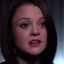

In [9]:
ttp(im_s[0])

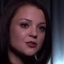

In [10]:
ttp(im_t[0])

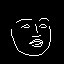

In [11]:
ttp(c_s[0][0][-1:,:,:])

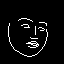

In [12]:
ttp(c_t[0][0][-1:,:,:])

In [13]:
im_s = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003350.png')).reshape(1,3,64,64).cuda()
im_t = tt(Image.open('/data/dajinhan/datasets/VoxCeleb/unzippedFaces_resized/64x64_png/Kellan_Lutz/1.6/482zKSvHeRw/0003400.png')).reshape(1,3,64,64).cuda()

c_s, c_t = sample_conditions(im_s, im_t)

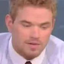

In [14]:
ttp(im_s[0])

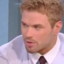

In [15]:
ttp(im_t[0])

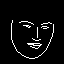

In [16]:
ttp(c_s[0][0][-1:,:,:])

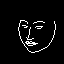

In [17]:
ttp(c_t[0][0][-1:,:,:])